# Modelo de Árvores de Decisão (Naufrágio do Titanic)

##### Bibliotecas importadas

In [341]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as pof
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import PIL

from IPython.display import Image

pof.init_notebook_mode(connected=True)

##### Aquisição e tratamento de dados

In [342]:
test_file = pd.read_csv('test.csv')
train_file = pd.read_csv('train.csv')
df_train = pd.DataFrame(train_file)
df_test = pd.DataFrame(test_file)
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

(None, None)

In [343]:
# conversão de qualified features em categorized features
# as qualified features serão transformadas em tabelas booleanas

##### Busca por valores Null ou vazios

Os vazios são interpretados como buracos no modelo que precisam ser tratados ou substituídos, ou removidos, dependendo da situação, no caso presente, os dados foram substituídos com a média da própria idade dos passageiros.

In [344]:
nulos = {'train': df_train.isnull().sum().sort_values(ascending=False), 'test': df_test.isnull().sum().sort_values(ascending=False)}
nulos_df = pd.DataFrame(nulos)
nulos_df

,train,test
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0
Name,0,0.0
Parch,0,0.0
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0


In [345]:
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)

# Quantificação de parentes por membro da tripulação
df_train['Family Members'] = df_train.loc[0:, ['Parch', 'SibSp']].sum(axis=1)
df_test['Family Members'] = df_test.loc[0:, ['Parch', 'SibSp']].sum(axis=1)

all_data = pd.merge(df_train, df_test, how='outer')

df_train.drop(['Parch', 'SibSp','PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)
df_test.drop(['Parch', 'SibSp', 'Ticket', 'Name', 'PassengerId'], axis=1, inplace=True)

# identificação se o passageiro teve cabine ou não
pointer = []
for item in df_train['Cabin']:
    if type(item) is float:
        pointer.append(0)
    else:
        pointer.append(1)
df_train['Has Cabin'] = pointer
df_train.drop(['Cabin'], axis=1, inplace=True)

pointer.clear()
for item in df_test['Cabin']:
    if type(item) is float:
        pointer.append(0)
    else:
        pointer.append(1)
df_test['Has Cabin'] = pointer
df_test.drop(['Cabin'], axis=1, inplace=True)

pointer.clear()

for index, item in enumerate(df_train['Embarked']):
    if type(item) == str:
        pointer.append(item)
    else:
        pointer.append(0)
        df_train.drop(index=index, axis=0, inplace=True)

Quantos familiares estavam embarcados por pessoa?

In [346]:
nulos = {
'Test': df_test.isnull().sum().sort_values(ascending=False),
'Train': df_train.isnull().sum().sort_values(ascending=False)
}
nulos_df = pd.DataFrame(nulos)
nulos_df
# sem valores nulos

,Test,Train
Age,0.0,0
Embarked,0.0,0
Family Members,0.0,0
Fare,0.0,0
Has Cabin,0.0,0
Pclass,0.0,0
Sex,0.0,0
Survived,NaN,0


In [347]:
new_data_train = pd.get_dummies(df_train)
new_data_test = pd.get_dummies(df_test)

<AxesSubplot:title={'center':'Heatmap: Feature correlations: '}>

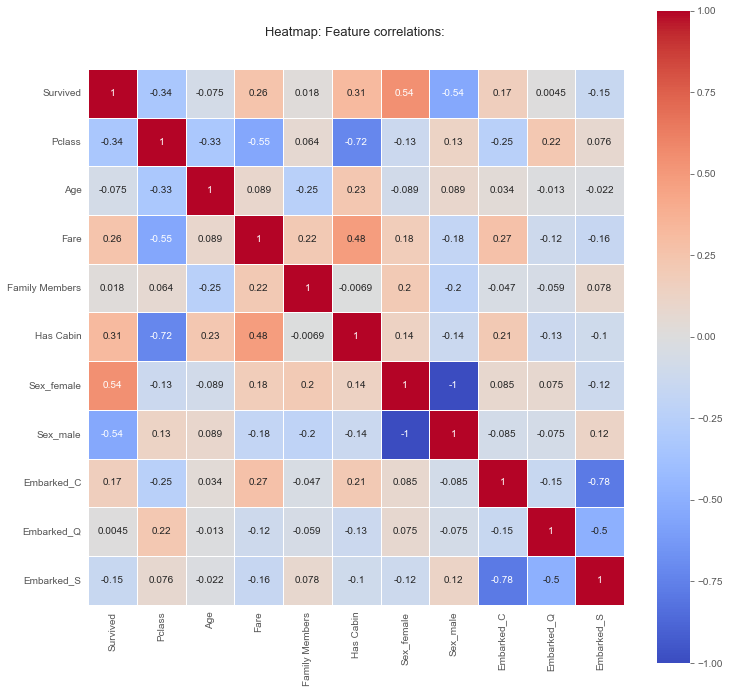

In [348]:
colormap = plt.cm.coolwarm
plt.figure(figsize=(12,12))
plt.title('Heatmap: Feature correlations: ', y=1.05, size=13)
sns.heatmap(new_data_train.astype(float).corr(),linewidths=0.5,vmax=1.0, vmin=-1, square=True, cmap=colormap, linecolor='white', annot=True)

##### Visualização das correlações:
As mais relevantes são as que mais destoam para 1 ou -1, interpretamos como:

1. Quanto mais próximos de 1, as correlações são fortes e favoráveis entre as variáveis.
2. Quanto mais próximo de 0, há baixa ou nenhuma correlação entre as variáveis.
3. Quanto mais próximo de -1, as correlações são fortes e desfavoráveis entre si.

As correlações se dão da seguinte maneira:

R é o coeficiente de Pearson
-1 < R < 1 e |R| <= 1

|R| <= 0.1: Nula
0.1< |R| <= 0.3: Fraca
0.3 < |R| <= 0.6: Moderada
0.6 < |R| <= 0.9: Forte
0.9 < |R| < 1: Muito Forte
|R| = 1: Perfeita

Vamos observar tal fenômeno com o mapa de calor e filtrar as principais na tabela do mesmo mapa que analisaremos a seguir.

1. Variáveis de relação forte e desfavoráveis entre si:

In [349]:
correlations = new_data_train.corr()
correlations.sort_values(ascending=True, by=['Survived'])
correlations = correlations[(correlations.Survived < -.1 )]
correlations.Survived

Pclass       -0.335549
Sex_male     -0.541585
Embarked_S   -0.151777
Name: Survived, dtype: float64

É possível observar que a interação entre os fatores 'sexo masculino', 'Pertencer a uma das classes', onde mais a frente veremos que se trata da 3a classe e 'embarcar em Southampton', foram fatores determinantes para as vítimas do naufrágio.

Só devemos nos atentar para o caso de 'embarcar em Southampton', pois não há uma correlação existente entre o momento em que a pessoa entrou no navio e ela não sobreviver ao naufrágio, tal correlação pode ser entendida de várias formas, seja como a maioria dos passageiros embarcou em Southampton ou por uma maior concentração destes passageiros nos dequeues inferiores, o que dificultou a fuga durante o naufrágio.

In [350]:
correlations = new_data_train.corr()
correlations.sort_values(ascending=True, by=['Survived'])
correlations = correlations[(correlations.Survived > .1 )]
correlations.Survived

Survived      1.000000
Fare          0.255290
Has Cabin     0.313435
Sex_female    0.541585
Embarked_C    0.169966
Name: Survived, dtype: float64

Entre os passageiros, podemos fazer a seguinte caracterização:

Nota: As colunas para representar o sexo da pessoa é do tipo booleana, logo, pessoas do sexo masculino serão 1 em "Sex_male" e 0 em "Sex_female" e vice-versa

In [351]:
new_data_train[['Fare', 'Sex_male', 'Sex_female']].groupby(['Sex_male', 'Sex_female'], as_index=False).agg(['mean', 'count'])

Fare      
                          mean count
Sex_male Sex_female                 
0        1           44.252124   312
1        0           25.523893   577

Entre os sobreviventes, temos:

In [352]:
data_view = new_data_train.loc[:,('Fare', 'Sex_male', 'Sex_female', 'Survived')]
data_view = data_view[(data_view.Survived == 1)]
data_view.drop(['Survived'], axis=1, inplace=True)
data_view[['Fare', 'Sex_male', 'Sex_female']].groupby(['Sex_male', 'Sex_female'], as_index=False).agg(['mean', 'count', 'sum'])


Fare                  
                          mean count         sum
Sex_male Sex_female                             
0        1           51.695617   231  11941.6876
1        0           40.821484   109   4449.5418

E entre os não sobreviventes, nós temos:

In [353]:
data_view = new_data_train.loc[:,('Fare', 'Sex_male', 'Sex_female', 'Survived')]
data_view = data_view[(data_view.Survived == 0)]
data_view.drop(['Survived'], axis=1, inplace=True)
data_view[['Fare', 'Sex_male', 'Sex_female']].groupby(['Sex_male', 'Sex_female'], as_index=False).agg(['mean', 'count', 'sum'])

Fare                  
                          mean count         sum
Sex_male Sex_female                             
0        1           23.024385    81   1864.9752
1        0           21.960993   468  10277.7447

Ao observar as correlações mais favoráveis a sobrevivência ao naufrágio, podemos observar que ser do 'sexo feminino', possuir uma cabine, ter pago um alto valor no ticket (Fare) e ter embarcado quem Cherbourg-Octeville/França foram fatores que contribuíram de maneira relevante aos sobreviventes.

Podemos atestar as correlações que observamos com gráficos, por exemplo, a correlação entre gênero:

In [354]:
all_men = len(new_data_train[new_data_train.Sex_male > 0])
all_men_survived = len(new_data_train[(new_data_train.Sex_male == 1) & (new_data_train.Survived == 1)])
all_women = len(new_data_train[new_data_train.Sex_female > 0])
all_women_survived = len(new_data_train[(new_data_train.Sex_female == 1) & (new_data_train.Survived == 1)])

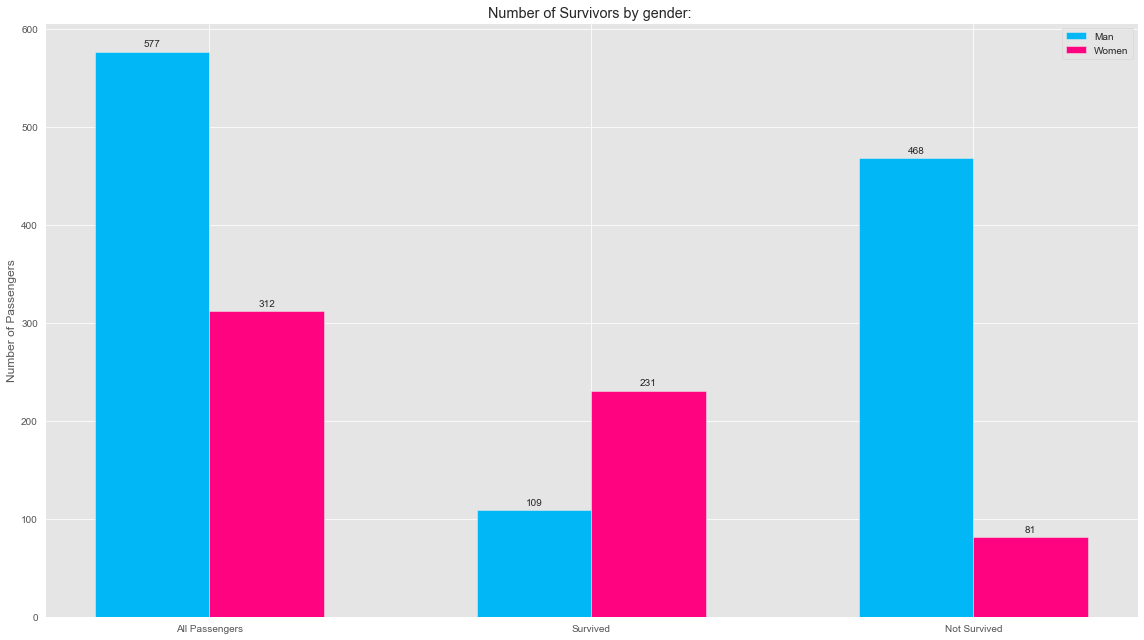

In [355]:
plt.style.use('ggplot')
labels = ['All Passengers', 'Survived', 'Not Survived']
level = 0
men_axes = [all_men, all_men_survived, all_men - all_men_survived]
women_axes = [all_women, all_women_survived, all_women - all_women_survived]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars
man = 'Man'
woman = 'Women'
fig, ax = plt.subplots(figsize=(16, 9))
rects1 = ax.bar(x - width/2, men_axes, width, label=man, color='#02B7F5')
rects2 = ax.bar(x + width/2, women_axes, width, label=woman, color='#FF0381')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Passengers')
ax.set_title('Number of Survivors by gender: ')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Podemos realizar a visualização através das classes em que cada passageiro possuía no navio.
Olhando para os sobreviventes, temos a seguinte distribuição:

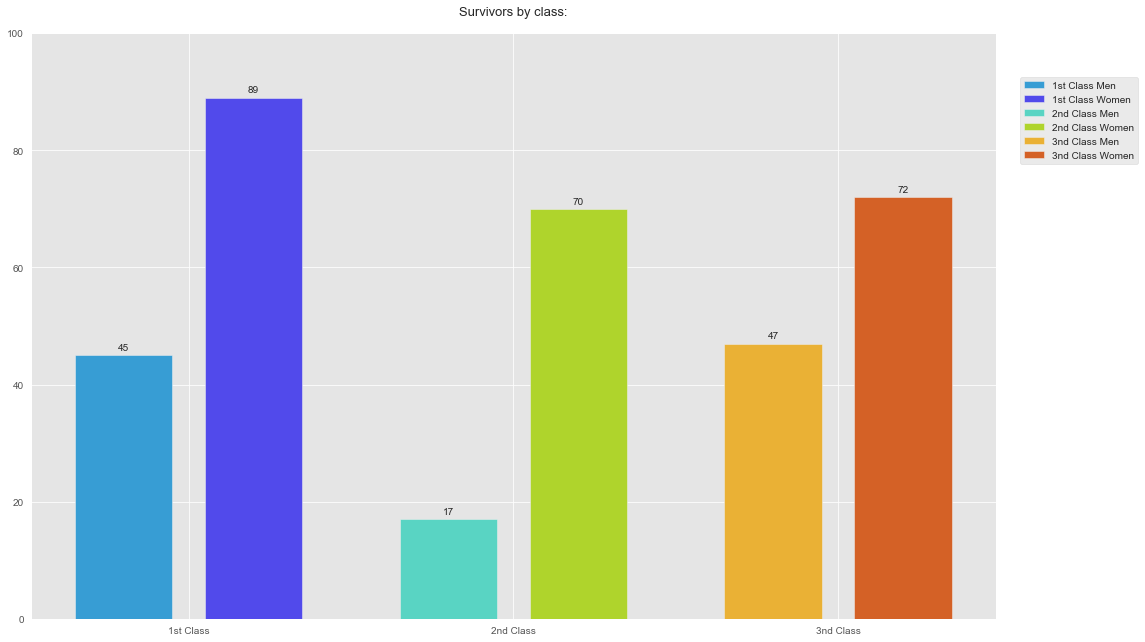

In [356]:
survives = new_data_train.loc[ :, ('Pclass', 'Survived', 'Sex_male', 'Sex_female')]
survives = survives[(survives.Survived == 1)]
survives.drop(['Survived'], axis=1, inplace=True)
labels = ['1st Class', '2nd Class', '3nd Class']
width = 0.15
x = np.arange(1)
fig, ax = plt.subplots(figsize=(16, 9))
c1 = ax.bar(x -0.60, len(survives[(survives.Pclass == 1) & (survives.Sex_male == 1)]), width, label='1st Class Men', color='#379DD4')
c2 = ax.bar(x -0.40, len(survives[(survives.Pclass == 1) & (survives.Sex_female == 1)]), width, label='1st Class Women', color='#514AEB')
c3 = ax.bar(x - 0.10, len(survives[(survives.Pclass == 2) & (survives.Sex_male == 1)]), width, label='2nd Class Men', color='#59D4C3')
c4 = ax.bar(x + 0.10, len(survives[(survives.Pclass == 2) & (survives.Sex_female == 1)]), width, label='2nd Class Women', color='#AFD42C')
c5 = ax.bar(x + 0.40, len(survives[(survives.Pclass == 3) & (survives.Sex_male == 1)]), width, label='3nd Class Men', color='#EAB135')
c6 = ax.bar(x+ 0.60, len(survives[(survives.Pclass == 3) & (survives.Sex_female == 1)]), width, label='3nd Class Women', color='#D46126')

ax.legend(bbox_to_anchor=(1.01, 0.95), loc=2, borderaxespad=1.5)
ax.set_title('Survivors by class:', y=1.02, size=13)
ax.set_xticks([-0.50, 0, 0.50], labels=labels)
ax.set_yticks([x * 20 for x in range(6)])

ax.bar_label(c1, padding=3)
ax.bar_label(c2, padding=3)
ax.bar_label(c3, padding=3)
ax.bar_label(c4, padding=3)
ax.bar_label(c5, padding=3)
ax.bar_label(c6, padding=3)

fig.tight_layout()
plt.show()

E entre as vitimas do naufrágio, temos:

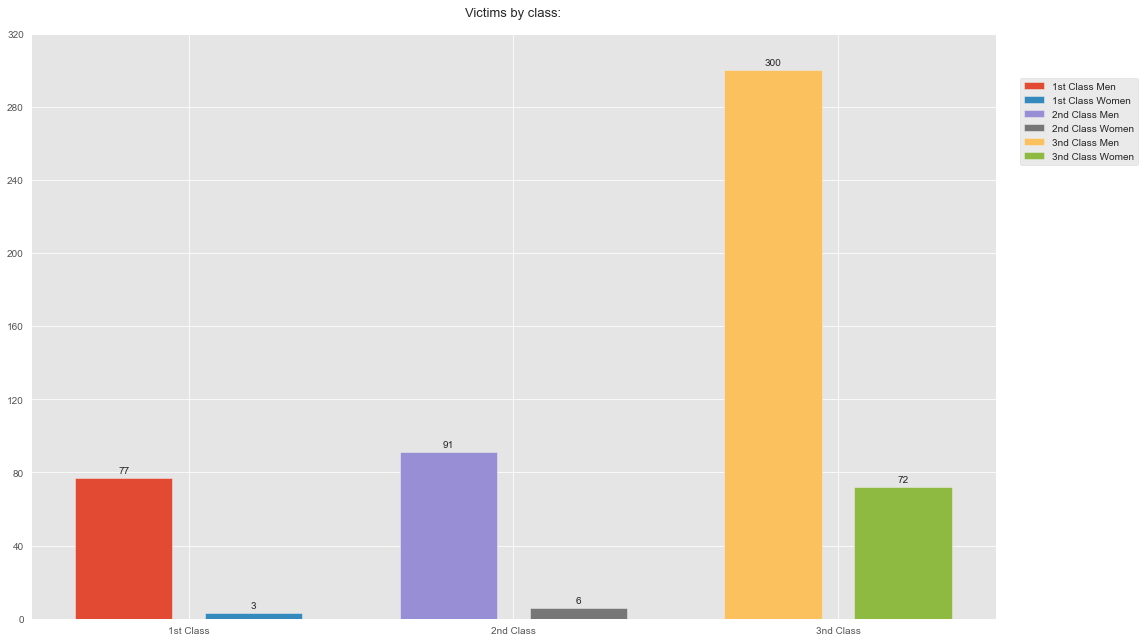

In [357]:
survives = new_data_train.loc[ :, ('Pclass', 'Survived', 'Sex_male', 'Sex_female')]
survives = survives[(survives.Survived == 0)]
survives.drop(['Survived'], axis=1, inplace=True)
labels = ['1st Class', '2nd Class', '3nd Class']
width = 0.15
x = np.arange(1)
fig, ax = plt.subplots(figsize=(16, 9))
c1 = ax.bar(x - 0.60, len(survives[(survives.Pclass == 1) & (survives.Sex_male == 1)]), width, label='1st Class Men')
c2 = ax.bar(x - 0.40, len(survives[(survives.Pclass == 1) & (survives.Sex_female == 1)]), width, label='1st Class Women')
c3 = ax.bar(x - 0.10, len(survives[(survives.Pclass == 2) & (survives.Sex_male == 1)]), width, label='2nd Class Men')
c4 = ax.bar(x + 0.10, len(survives[(survives.Pclass == 2) & (survives.Sex_female == 1)]), width, label='2nd Class Women')
c5 = ax.bar(x + 0.40, len(survives[(survives.Pclass == 3) & (survives.Sex_male == 1)]), width, label='3nd Class Men')
c6 = ax.bar(x+ 0.60, len(survives[(survives.Pclass == 3) & (survives.Sex_female == 1)]), width, label='3nd Class Women')

ax.legend(bbox_to_anchor=(1.01, 0.95), loc=2, borderaxespad=1.5)
ax.set_title('Victims by class:', y=1.02, size=13)
ax.set_xticks([-0.50, 0, 0.50], labels=labels)
ax.set_yticks([x * 40 for x in range(9)])

ax.bar_label(c1, padding=3)
ax.bar_label(c2, padding=3)
ax.bar_label(c3, padding=3)
ax.bar_label(c4, padding=3)
ax.bar_label(c5, padding=3)
ax.bar_label(c6, padding=3)

fig.tight_layout()
plt.show()

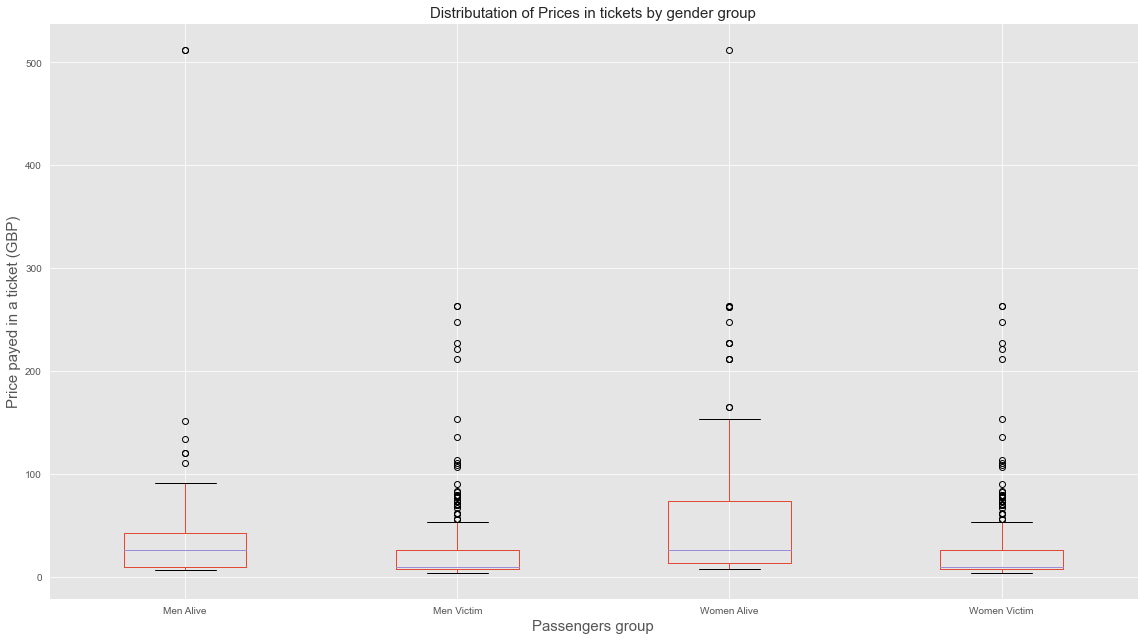

In [358]:
fare_by_men_alive = new_data_train[(new_data_train.Sex_male == 1) & (new_data_train.Fare > 0) & (new_data_train.Survived == 1)]
fare_by_men_victim = new_data_train[(new_data_train.Sex_male == 1) & (new_data_train.Fare > 0) & (new_data_train.Survived == 0)]
fare_by_women_alive = new_data_train[(new_data_train.Sex_female == 1) & (new_data_train.Fare > 0) & (new_data_train.Survived == 1)]
fare_by_women_victim = new_data_train[(new_data_train.Sex_female == 1) & (new_data_train.Fare > 0) & (new_data_train.Survived == 0)]
dicts = {
    'Men Alive': fare_by_men_alive.Fare,
    'Men Victim': fare_by_men_victim.Fare,
    'Women Alive': fare_by_women_alive.Fare,
    'Women Victim': fare_by_men_victim.Fare
}
plt.subplots(figsize=(16, 9))
plt.xlabel('Passengers group', size=15, y=1.03)
plt.ylabel('Price payed in a ticket (GBP)', size=15)
plt.title('Distributation of Prices in tickets by gender group', size=15)
colors = ['blue', 'purple', 'pink', 'red']
data_view = pd.DataFrame(dicts)
boxplot = data_view.boxplot()
boxplot.plot()
plt.tight_layout()
plt.show()

In [359]:
age_u18 = new_data_train[(new_data_train.Age < 18)]
age_u30 = new_data_train[(18 <=  new_data_train.Age) & (new_data_train.Age < 30)]
age_u40 = new_data_train[(30 <=  new_data_train.Age) & (new_data_train.Age < 40)]
age_u50 = new_data_train[(40 <=  new_data_train.Age) & (new_data_train.Age < 50)]
age_u60 = new_data_train[(50 <=  new_data_train.Age) & (new_data_train.Age < 60)]
age_a60 = new_data_train[(new_data_train.Age >= 60)]


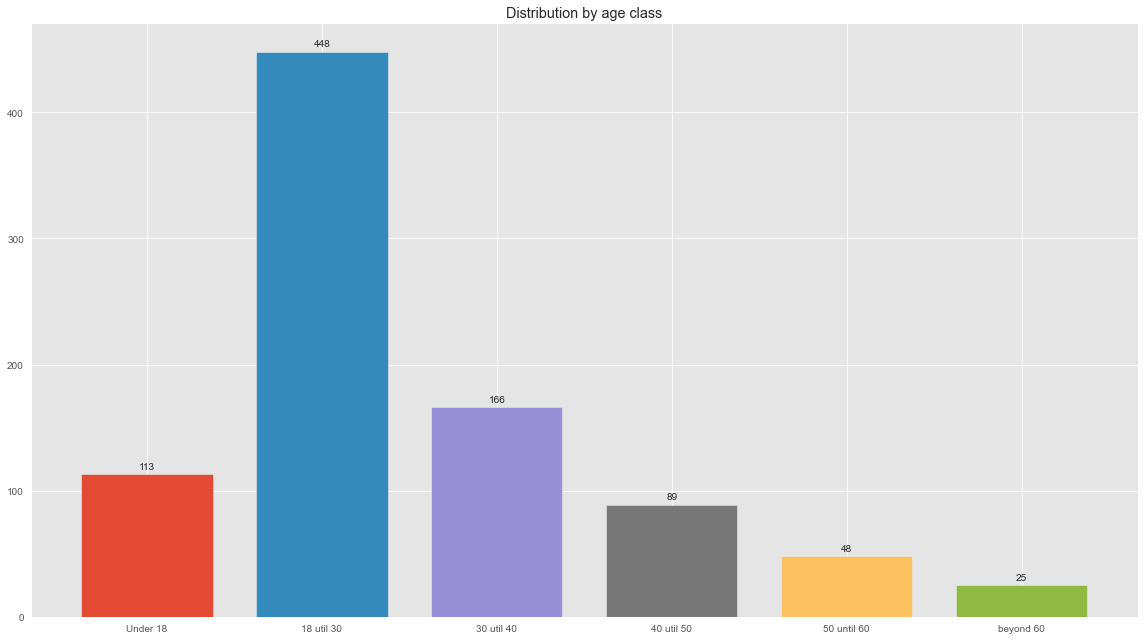

In [360]:
fig, ax = plt.subplots(figsize=(16, 9))
oage_u18 = age_u18[['Age']]
oage_u30 = age_u30[['Age']]
oage_u40 = age_u40[['Age']]
oage_u50 = age_u50[['Age']]
oage_u60 = age_u60[['Age']]
oage_a60 = age_a60[['Age']]
labels = ['Under 18', '18 util 30', '30 util 40', '40 util 50', '50 until 60', 'beyond 60']
width = 0.15
x = np.arange(1)

u18 = ax.bar(x, len(oage_u18), width=width, label='U18')
u30 = ax.bar(x + .20, len(oage_u30), width=width, label='U30')
u40 = ax.bar(x + .40, len(oage_u40), width=width, label='U40')
u50 = ax.bar(x + .60, len(oage_u50), width=width, label='U50')
u60 = ax.bar(x + .80, len(oage_u60), width=width, label='U60')
a60 = ax.bar(x + 1, len(oage_a60), width=width, label='Beyond 60')

ax.bar_label(u18, padding=3)
ax.bar_label(u30, padding=3)
ax.bar_label(u40, padding=3)
ax.bar_label(u50, padding=3)
ax.bar_label(u60, padding=3)
ax.bar_label(a60, padding=3)
ax.set_title('Distribution by age class')
ax.set_xticks([a *.20 for a in range(6)], labels = labels)
ax.grid(True)
fig.tight_layout()
plt.show()

Criando o modelo

In [361]:
Y = new_data_train['Survived']
X = new_data_train.drop(['Survived'], axis=1)

tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X, Y)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [362]:
tree.score(X, Y)

0.8233970753655793

In [363]:
x_train, y_train, x_test, y_test = train_test_split(new_data_train, new_data_test, test_size=0.2, random_state=0)

ValueError: Found input variables with inconsistent numbers of samples: [889, 418]

In [ ]:
Logisctic_classifier = LogisticRegression(solver = 'liblinear',max_iter = 100)
Logisctic_classifier.fit(x_train, y_train)

y_pred = Logisctic_classifier.predict(x_test)

print(classification_report(y_test,y_pred),end = '\n')
print('\n')
print(confusion_matrix(y_test,y_pred),end = '\n')
print('\n')
print('logistic regression accuracy: {:.2f}%'.format(accuracy_score(y_pred,y_test)*100),end = '\n')